# Product type classification from its name and discription

Given a training set for product type classification. The task is to build a model to predict the column label, using the other columns as input


*Column explanations:*
* sku_id – product id
* country_name – name of the country in which the product was found
* retailer – name of the retailer in which the product was found
* breadcrumbs – breadcrumbs, where breadcrumbs show the path of the product in the retailer taxonomy tree
* breadcrumbs_t – translated breadcrumbs
* name – name of the product
* name_t – translated name
* pack_size – pack size field of the product
* pack_size_t – translated pack size
* description_short – product description, possibly truncated to keep maximum length fixed
* description_t_short – translated description
* resnet50_labels_005 – categories predicted by an image classifier, thresholded at 0.05
confidence, joined with '~'
* resnet50_labels_06 – categories predicted by an image classifier, thresholded at 0.6 confidence
* price – price of the product in USD
* label – product type, this is the target to predict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams

nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn import metrics

!pip install autocorrect
from autocorrect import Speller
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

spell = Speller(lang='en')

import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,9)})

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data loading & initial analysis / processing

In [ ]:
d = pd.read_csv("/content/drive/MyDrive/***/train.csv")
d.head()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","[""""Beauty & Personal Care"""",""""Tools & Accessor...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","[""""Free From"""",""""Free From Chilled & Meat"""",""""...",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","[""""Pantry & Household"""",""""Household Supplies""""...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","[""""Vitamins"""",""""Herbals""""]",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/***/test.csv")

Check for missing values

In [ ]:
d.isna().sum()

sku_id                    0
country_name              0
retailer                  0
breadcrumbs               0
breadcrumbs_t             0
name                      0
name_t                    0
pack_size              3294
pack_size_t            3295
description_short       979
description_t_short     980
resnet50_labels_005      91
resnet50_labels_06     2675
price                   163
label                     0
label_id                  0
dtype: int64

As we can see, there are a few omissions, but we will use NLP to solve this problem, so we will keep only these columns: 


*   retailer
*   breadcrumbs_t
*   name_t
*   description_t_short




In [ ]:
d.drop(['pack_size', 'pack_size_t', 'name', 'breadcrumbs', 'description_short', 'price'], axis=1, inplace=True)  

Let's check how our data is distributed over different classes.
From pie chart bellow we can clearly see that dataset is unbalanced. There is ~83% observation that belongs to *OUT OF SCOPE* class and the rest share is spread almost evenly.

In [ ]:
d['label'].value_counts()

OUT OF SCOPE          3304
Men's Fragrances       193
Women's Fragrances     188
Dry Dog Food           102
Flavoured Yoghurt       80
Wet Dog Food            67
Plain Yoghurt           49
Name: label, dtype: int64

Text(0.5, 1.0, 'labels percentage')

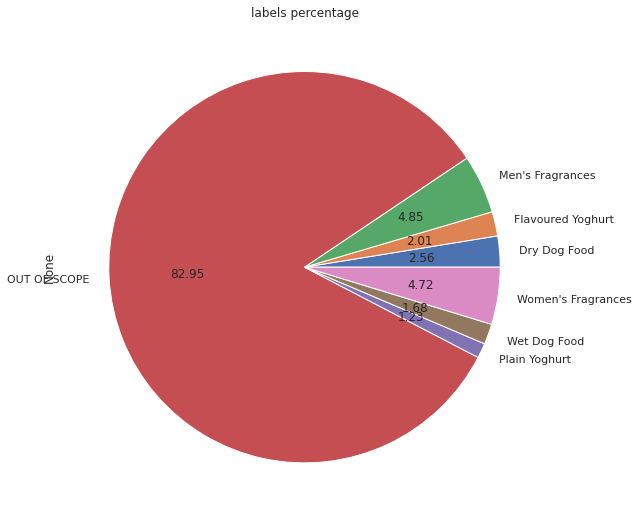

In [ ]:
d.groupby('label').size().plot(kind='pie', autopct='%.2f')
plt.title('labels percentage')

As I mentoined above, data set is unbalanced, so in this case to avoid one class bias, dataset was downsampled. Downsampled dataset pie chart is show below, all clases share is equal.

In [ ]:
g = d.groupby('label', group_keys=False)
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)

Text(0.5, 1.0, 'labels percentage')

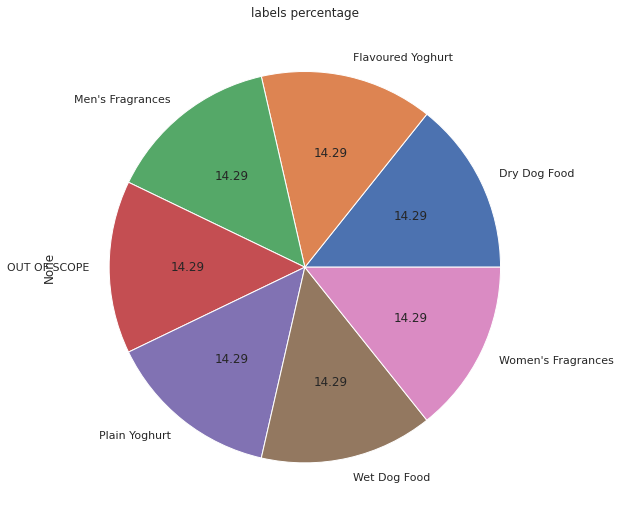

In [ ]:
balanced_df.groupby('label').size().plot(kind='pie', autopct='%.2f')
plt.title('labels percentage')

Before any ML model, text data must be cleaned and preprocessed, in this case just main preprocessing steps were made:
*   data cleaning from special characters, tabs and ect;
*   tokenization;
*   words with length less than 3 have been filtered out;
*   all letters have been changed to lowercase;
*   stop words removed.

NOTE: additional spelling correction function used, because grammatical errors such as: yougurt, yougurth, youghurt, etc. were observed during the analysis.

In [ ]:
def clean_special_char(text):
  #expression = '[^a-zA-Z0-9]'
  clean = re.sub('[^a-zA-Z]+', ' ', str(text))

  tag = ''
  for x in nltk.word_tokenize(clean):
    if len(x)>2 and x not in stop_words:
      tag = tag + x + ' '
      #tag = tag + spell(x) + ' '

  return tag.strip().lower()

Feature vector consist of concatenated breacrumbs, name and short discription texts.

In [ ]:
# tokenize and clean tags
balanced_df['breadcrumbs_t'] = balanced_df['breadcrumbs_t'].apply(clean_special_char)
balanced_df['description_t_short'] = balanced_df['description_t_short'].apply(clean_special_char)
balanced_df['name_t'] = balanced_df['name_t'].apply(clean_special_char)
balanced_df['retailer'] = balanced_df['retailer'].apply(clean_special_char)

balanced_df['full_text'] = balanced_df['breadcrumbs_t'] + balanced_df['description_t_short'] + balanced_df['name_t'] + balanced_df['retailer']

df=balanced_df

In [ ]:
df.head()

,sku_id,country_name,retailer,breadcrumbs_t,name_t,description_t_short,resnet50_labels_005,resnet50_labels_06,label,label_id,full_text
0,59055535,Spain,mascota planet,dogs food think think belcando adult,belcando adult finest light,belcando adult finest lightpropiedadessabroso ...,binder~book_jacket~cassette~packet~wallet,NaN,Dry Dog Food,2,dogs food think think belcando adultbelcando a...
1,222757306,Germany,miscota,dogs dog food dry food dogs,prestige junior maxi,prestige junior maxi sole food puppy big breed...,monitor~screen~television~web_site,NaN,Dry Dog Food,2,dogs dog food dry food dogsprestige junior max...
2,221684774,Brazil,genmarket,pet shop dogs food accessories ration medicame...,ration royal canin fall intestinal low fat,ration royal canin fall intestinal low fat,envelope~packet~plastic_bag,NaN,Dry Dog Food,2,pet shop dogs food accessories ration medicame...
3,20293961,United Kingdom,sainsburys,pet dog puppy complete dry dog food,bakers puppy food beef vegetable,information description complete pet food pupp...,Band_Aid~can_opener~packet~web_site,NaN,Dry Dog Food,2,pet dog puppy complete dry dog foodinformation...
4,19935050,United Kingdom,sainsburys,pet dog puppy senior dog years dry dog food,vet kitchen senior years salmon brown rice,information description reduced protein fat fi...,cassette~hand-held_computer~web_site,NaN,Dry Dog Food,2,pet dog puppy senior dog years dry dog foodinf...


### Training

Spliting dataset into test and train data sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], df['label'], test_size=0.2, random_state=144)

#### Simple TF-IDF with Multinomial Naive Bayes classifier
Initializing Multinomial Naive Bayes classification model and text feature vector was vectorized using TF-IDF char ngram statistic.


In [ ]:
model = make_pipeline(TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,4), max_features=5000), MultinomialNB())
#model = make_pipeline(TfidfVectorizer(
#    sublinear_tf=True,
#    strip_accents='unicode',
#    analyzer='char',
#    #stop_words='english',
#    ngram_range=(2, 6),
#    max_features=50000), MultinomialNB())



In [ ]:
model.fit(df['full_text'], df['label_id'])
labels = model.predict(X_test)

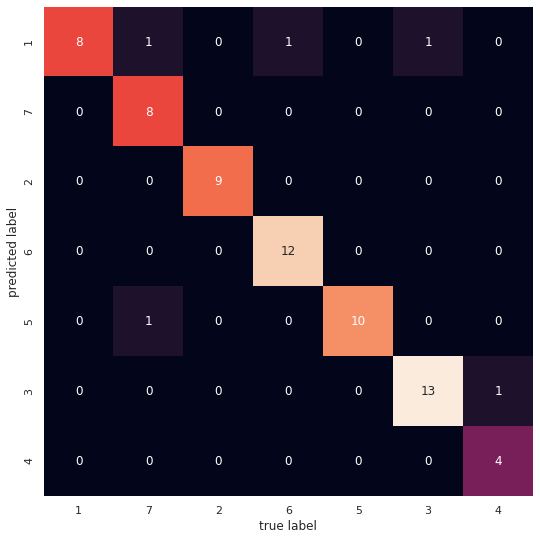

In [ ]:
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(d.label_id.unique()), yticklabels=list(d.label_id.unique()))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, labels, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

Accuracy of the model on Testing Sample Data: 0.93


Predicting test data that was given in task.
Of course we will apply the same cleaning process to the test data before classification

In [ ]:
# tokenize and clean tags
test['breadcrumbs_t'] = test['breadcrumbs_t'].apply(clean_special_char)
test['description_t_short'] = test['description_t_short'].apply(clean_special_char)
test['name_t'] = test['name_t'].apply(clean_special_char)
test['retailer'] = test['retailer'].apply(clean_special_char)

test['full_text'] = test['breadcrumbs_t'] + test['description_t_short'] + test['name_t'] + test['retailer']

In [ ]:
test['label_id'] = model.predict(test['full_text'])
results = test[['sku_id', 'label_id']]

In [ ]:
#char_res = pd.read_csv('/content/drive/MyDrive/***/classification_results.csv')
results.to_csv('/content/drive/MyDrive/***/classification_results_retail.csv')

In [ ]:
char_res.tail()

In [ ]:
results.tail()

In this project just simple feature vector was produced. 

Retailers could be taken into account, as we can see they differ between classes, especialy between similar classes (men and women fragnaces)

In [ ]:
retailers_1 = d[d.label_id==6].retailer.unique() # flavored yoghurt
retailers_1

In [ ]:
retailers_2 = d[d.label_id==7].retailer.unique() # plain yoghurt
retailers_2

In [ ]:
difs = list(set(retailers_1) - set(retailers_2))
difs

### Test on unbalanced dataset that have labels

In [ ]:
unbalanced_df = pd.concat([balanced_df, d]).drop_duplicates(keep=False)

In [ ]:
# tokenize and clean tags
unbalanced_df['breadcrumbs_t'] = unbalanced_df['breadcrumbs_t'].apply(clean_special_char)
unbalanced_df['description_t_short'] = unbalanced_df['description_t_short'].apply(clean_special_char)
unbalanced_df['name_t'] = unbalanced_df['name_t'].apply(clean_special_char)
unbalanced_df['retailer'] = unbalanced_df['retailer'].apply(clean_special_char)

unbalanced_df['full_text'] = unbalanced_df['breadcrumbs_t'] + unbalanced_df['description_t_short'] + unbalanced_df['name_t'] + unbalanced_df['retailer']

Accuracy of the model on Testing Sample Data: 0.72


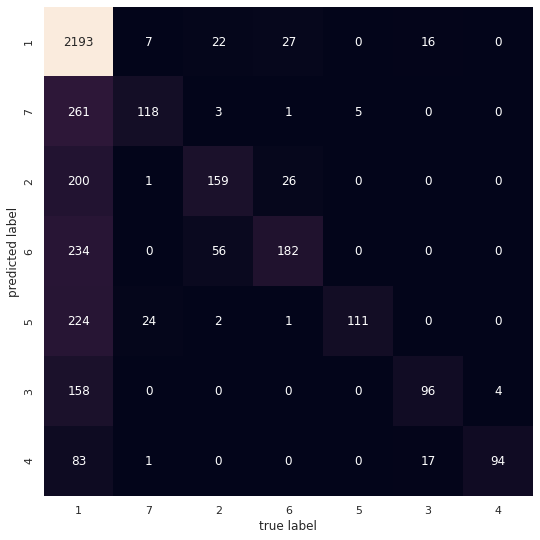

In [ ]:
#model.fit(unbalanced_df['full_text'], unbalanced_df['label_id'])
labels = model.predict(unbalanced_df['full_text'])

mat = confusion_matrix(unbalanced_df['label_id'], labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(d.label_id.unique()), yticklabels=list(d.label_id.unique()))
plt.xlabel('true label')
plt.ylabel('predicted label')


# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(unbalanced_df['label_id'], labels, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

* LDA embeddings
* Weight title, description and ect.
* Define keywords in each class
* pretrained doc2vec or word2vec for embedding and keywords similarity 
* ...
* description lengths analysis
* simple regex for pattern searching (class name)
* analyse products by countries
* 

## TSNE

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE


vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,4), max_features=300)

In [ ]:
tst = vectorizer.fit_transform(df['full_text']).toarray()
tst

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X = preprocessing.normalize(tst)
y = df['label']
le = LabelEncoder()
y = le.fit_transform(y)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

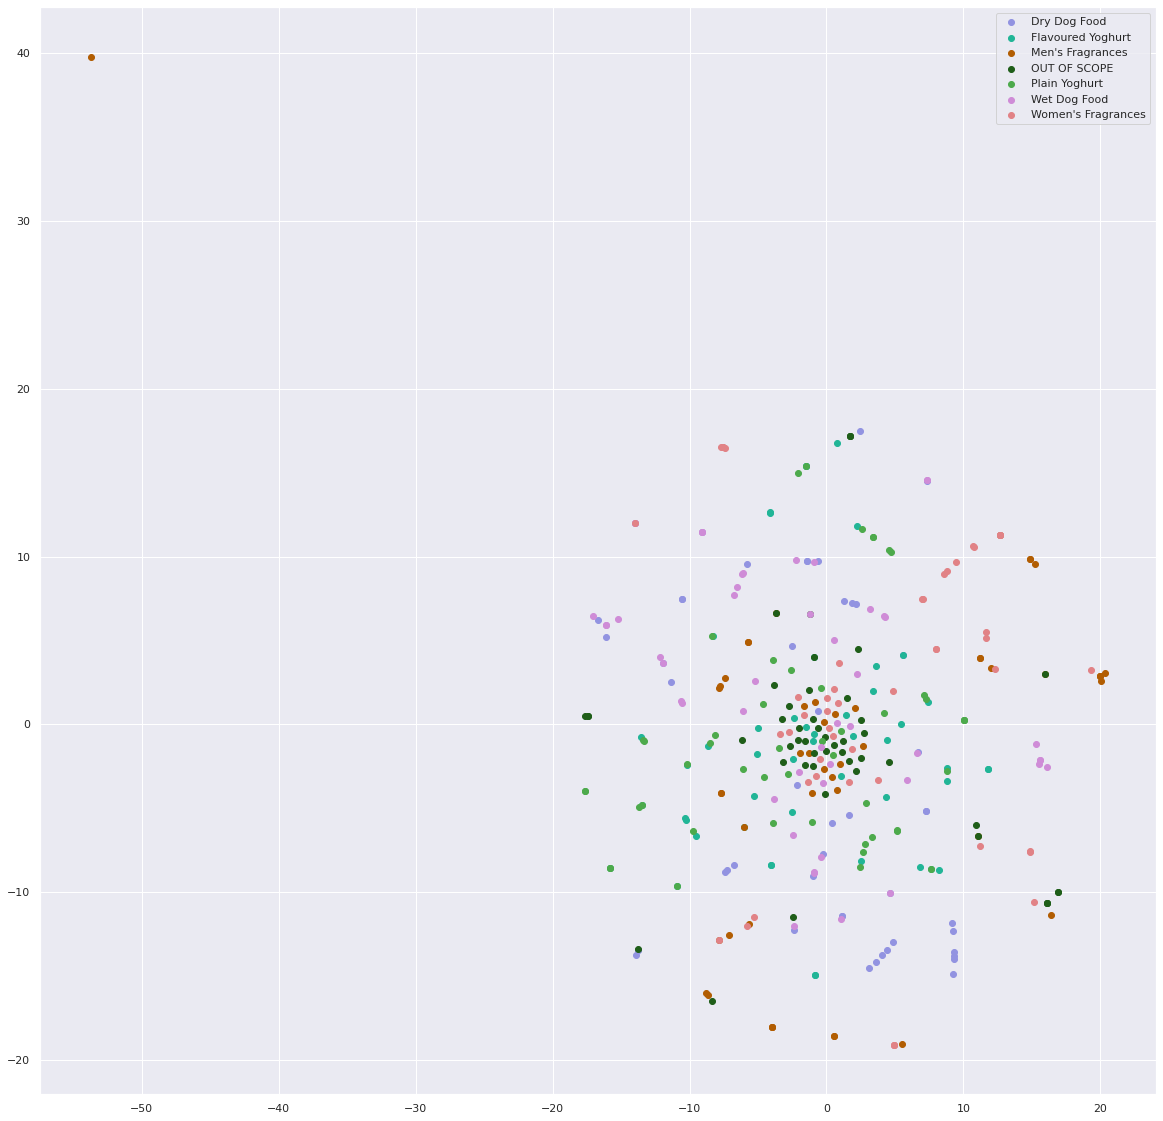

In [ ]:
tsne = TSNE(n_components=2, random_state=144)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

### BERT classifier

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 3.3 MB 17.6 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 636 kB 26.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel


In [ ]:
#d['description_t_short'] = d['description_t_short'].apply(clean_special_char)
# tokenize and clean tags
d['breadcrumbs_t'] = d['breadcrumbs_t'].apply(clean_special_char)
d['description_t_short'] = d['description_t_short'].apply(clean_special_char)
d['name_t'] = d['name_t'].apply(clean_special_char)
d['retailer'] = d['retailer'].apply(clean_special_char)

d['full_text'] = d['breadcrumbs_t'] + d['description_t_short'] + d['name_t'] + d['retailer']

d.head()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id,full_text
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...",beauty personal care tools accessories cotton ...,"Q-tips Cotton Swabs, 170 ct",tips cotton swabs,NaN,NaN,q-tips cotton swabs have a wide variety of use...,tips cotton swabs wide variety uses including ...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1,beauty personal care tools accessories cotton ...
1,60540,USA,chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...",dog bowls feeders fountains filters,"Petmate Fresh Flow Replacement Filters, 6 count",petmate fresh flow replacement filters count,8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description petmate deluxe fresh flow replacem...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1,dog bowls feeders fountains filtersdescription...
2,96170,United Kingdom,asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...",free from free from chilled meat spreads chees...,ASDA Free From Plain Soya Yogurt,asda free from plain soya yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content grams lifestyle suitable vegetaria...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7,free from free from chilled meat spreads chees...
3,116045,USA,jet com,"[""""Pantry & Household"""",""""Household Supplies""""...",pantry household household supplies insect pes...,"Off! Deep Woods Dry Aerosol, 4 Oz",off deep woods dry aerosol,12,12,description specs includes 25% deet formula. p...,description specs includes deet formula provid...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1,pantry household household supplies insect pes...
4,120858,USA,cvs,"[""""Vitamins"""",""""Herbals""""]",vitamins herbals,Nature's Answer Damiana Leaf Vegetarian Capsul...,nature answer damiana leaf vegetarian capsules,90 CT,90 CT,nature's answer capsules feature the highest q...,nature answer capsules feature highest quality...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1,vitamins herbalsnature answer capsules feature...


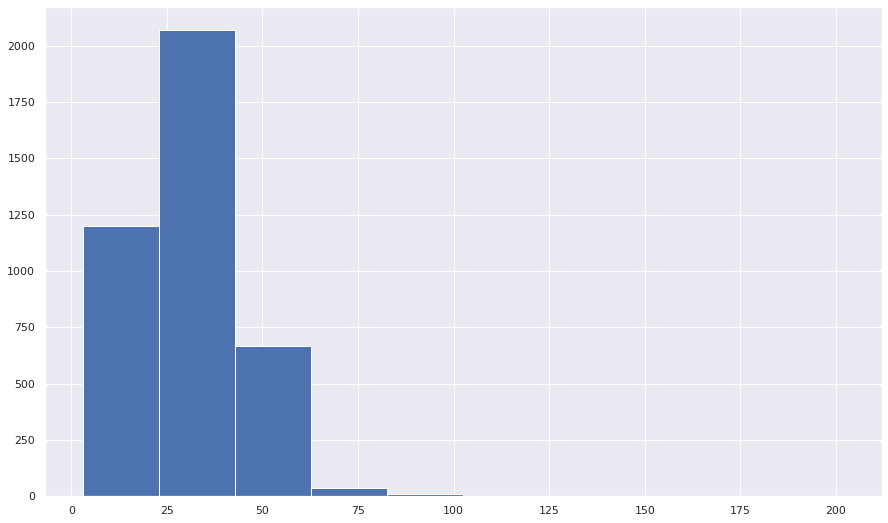

In [ ]:
d.full_text.str.split().str.len().hist()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(d['description_t_short'], d['label_id'], test_size=0.2, random_state=144)
X_train, X_test, y_train, y_test = train_test_split(d['full_text'], d['label_id'], test_size=0.2, random_state=144)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
(y_train.shape, y_test.shape)

((3186, 7), (797, 7))

In [ ]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
for layer in bert.layers:
      layer.trainable = True

In [ ]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)

## Build the model

In [ ]:
# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(7,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [ ]:
model = build_model(bert, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=15
)

Epoch 1/15
100/100 [==============================] - 80s 638ms/step - loss: 0.7175 - accuracy: 0.8258 - val_loss: 0.4025 - val_accuracy: 0.8444
Epoch 2/15
100/100 [==============================] - 62s 617ms/step - loss: 0.3144 - accuracy: 0.8967 - val_loss: 0.2471 - val_accuracy: 0.9172
Epoch 3/15
100/100 [==============================] - 62s 616ms/step - loss: 0.2022 - accuracy: 0.9338 - val_loss: 0.1872 - val_accuracy: 0.9423
Epoch 4/15
100/100 [==============================] - 62s 616ms/step - loss: 0.1510 - accuracy: 0.9488 - val_loss: 0.1981 - val_accuracy: 0.9473
Epoch 5/15
100/100 [==============================] - 62s 616ms/step - loss: 0.1215 - accuracy: 0.9576 - val_loss: 0.1973 - val_accuracy: 0.9448
Epoch 6/15
100/100 [==============================] - 62s 616ms/step - loss: 0.0876 - accuracy: 0.9718 - val_loss: 0.1933 - val_accuracy: 0.9460
Epoch 7/15
100/100 [==============================] - 61s 615ms/step - loss: 0.0794 - accuracy: 0.9711 - val_loss: 0.1934 - val_ac

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#### Training loss

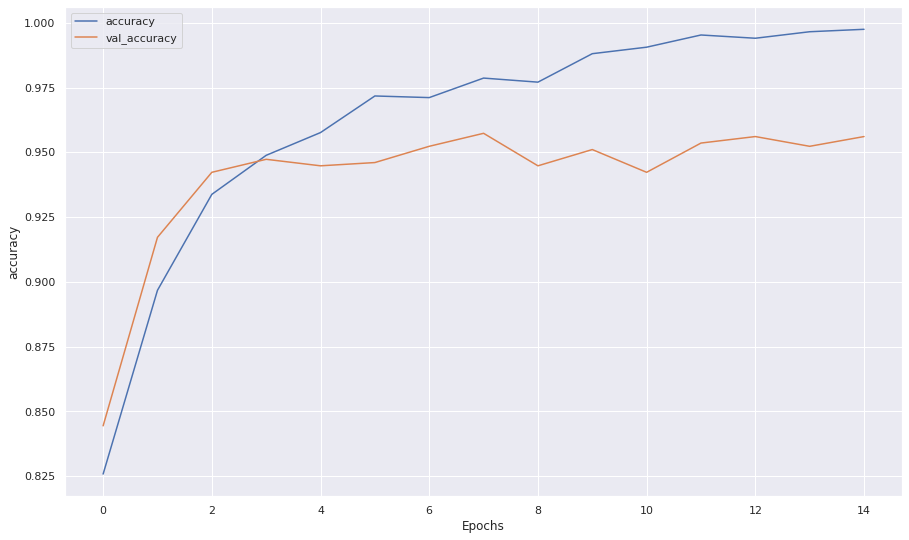

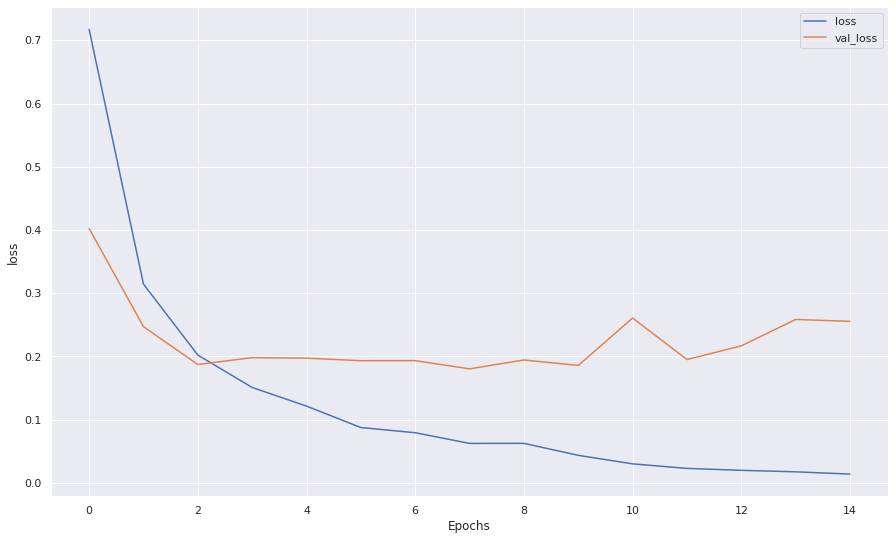

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

25/25 [==============================] - 5s 198ms/step - loss: 0.2556 - accuracy: 0.9561
Test accuracy : 0.9560853242874146


## PREDICT

In [ ]:
# tokenize and clean tags
test['breadcrumbs_t'] = test['breadcrumbs_t'].apply(clean_special_char)
test['description_t_short'] = test['description_t_short'].apply(clean_special_char)
test['name_t'] = test['name_t'].apply(clean_special_char)
test['retailer'] = test['retailer'].apply(clean_special_char)

test['full_text'] = test['breadcrumbs_t'] + test['description_t_short'] + test['name_t'] + test['retailer']

test.head()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,full_text
0,193691,United Kingdom,amazon,"[""""Fragrances"""",""""Women"""",""""Perfume Oils""""]",fragrances women perfume oils,Dark Velvet Perfume Oil for Women by Al Aneeq ...,dark velvet perfume oil women aneeq,NaN,NaN,fast & free shipping our own unique al aneeq b...,fast free shipping unique aneeq branded perfum...,lotion~sunscreen,NaN,6.246157,fragrances women perfume oilsfast free shippin...
1,194042,USA,jet com,"[""""Pantry & Household"""",""""Household Supplies""""...",pantry household household supplies laundry ot...,SCOTCH-BRITE 50% STICKIER LARGE SURFACE LINT R...,scotch brite stickier large surface lint rolle...,1 each,1 each,description specs the only lint roller made wi...,description specs lint roller made scotch bran...,carton~microwave~packet~washer,NaN,9.730000,pantry household household supplies laundry ot...
2,225668,United Kingdom,sainsburys,"[""""food-cupboard"""",""""baking-powder---raising-a...",food cupboard baking powder raising agents,Sainsbury's Fast Action Dried Yeast Sachets x8...,sainsbury fast action dried yeast sachets,NaN,NaN,information description dried yeast essential ...,information description dried yeast essential ...,envelope~web_site,NaN,1.072572,food cupboard baking powder raising agentsinfo...
3,351205,USA,amazon,"[""""Beauty & Personal Care"""",""""Shave & Hair Rem...",beauty personal care shave hair removal men ra...,Feather Styling Razor Disposal Case,feather styling razor disposal case,NaN,NaN,dispose used blades safely the cutting perform...,dispose used blades safely cutting performance...,pencil_sharpener~printer~switch,switch,4.860000,beauty personal care shave hair removal men ra...
4,374160,USA,amazon,"[""""Clothing, Shoes & Jewelry"""",""""Men"""",""""Shoes""""]",clothing shoes jewelry men shoes,Guide Gear Mens Nylon Snake Boots Waterproof S...,guide gear mens nylon snake boots waterproof s...,NaN,NaN,NaN,nan,Christmas_stocking~cowboy_boot,cowboy_boot,99.990000,clothing shoes jewelry men shoesnanguide gear ...


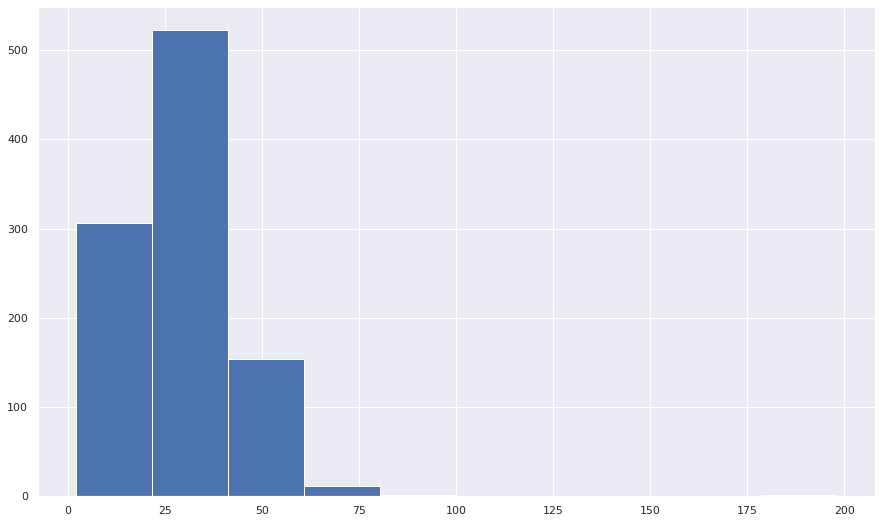

In [ ]:
test.full_text.str.split().str.len().hist()

In [ ]:
final_test_input_ids, final_test_attention_mask = text_encode(test['full_text'], tokenizer, max_len=100)

In [ ]:
pred = model.predict([final_test_input_ids, final_test_attention_mask])

pred_labels = np.argmax(pred, axis=1)
print(pred_labels)

[3 0 0 0 0 4 0 0 0 0 0 0 0 5 0 0 5 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0 0
 5 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 2 1 0 0 0 0 0 0 2 0 0 4 0 3 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0
 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 3 0 0 0 0 0 1 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 5 0 0 0 0 0 4 2 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 5 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 1 2 0
 2 0 6 0 5 0 0 0 0 3 3 0 1 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 5 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 4 1 2 2 0 2 0 0 0 0 0 4 0 2 0 3 0 0 0 0 6 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 5 3 0 6 0 4 0 5 0 0
 0 2 0 0 0 0 0 0 0 6 0 2 0 0 0 3 4 4 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 4 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 0 3 0 0 6 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 6 

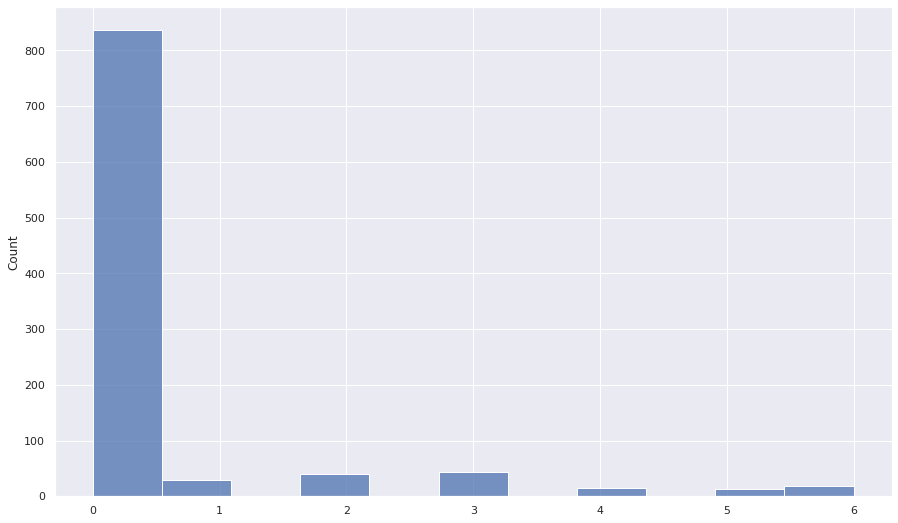

In [ ]:
sns.histplot(pred_labels)

In [ ]:
final_preds = encoder.inverse_transform(pred_labels)
final_preds

array([4, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1,
       3, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 5, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1,
       7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 6, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 7, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 7, 1, 6,

In [ ]:
results

,sku_id,label_id
0,193691,4
1,194042,1
2,225668,1
3,351205,1
4,374160,1
...,...,...
990,271665484,1
991,275348804,1
992,275400954,1
993,276209365,1


In [ ]:
test['label_id'] = final_preds
results = test[['sku_id', 'label_id']]

results.to_csv('/content/drive/MyDrive/***/classification_results_BERT.csv')

Text(0.5, 1.0, 'labels percentage')

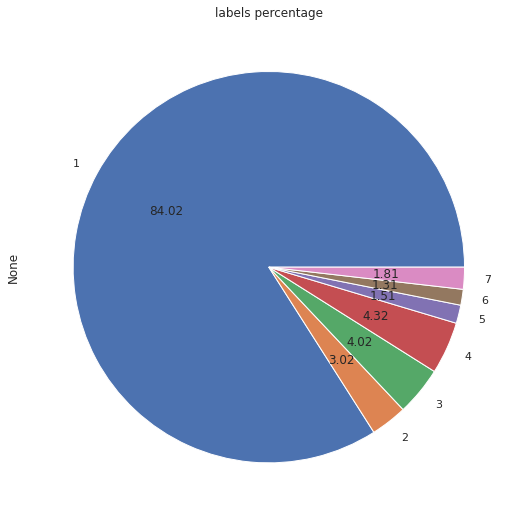

In [ ]:
results.groupby('label_id').size().plot(kind='pie', autopct='%.2f')
plt.title('labels percentage')